### Synthetic array == True

In [1]:
import deepmimo as dm
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import sionna
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, DirectivePattern, PathSolver
from deepmimo.exporters.sionna_exporter import export_paths

def compute_array_combinations(arrays):
    return np.stack(np.meshgrid(*arrays), -1).reshape(-1, len(arrays))

def gen_user_grid(box_corners, steps, box_offsets=None):
    """
    box_corners is = [bbox_min_corner, bbox_max_corner]
    steps = [x_step, y_step, z_step]
    """

    # Sample the ranges of coordinates
    ndim = len(box_corners[0])
    dim_ranges = []
    for dim in range(ndim):
        if steps[dim]:
            dim_range = np.arange(box_corners[0][dim], box_corners[1][dim], steps[dim])
        else:
            dim_range = np.array([box_corners[0][dim]]) # select just the first limit

        dim_ranges.append(dim_range + box_offsets[dim] if box_offsets else 0)

    pos = compute_array_combinations(dim_ranges)
    print(f'Total positions generated: {pos.shape[0]}')
    return pos


def create_base_scene(scene_path, center_frequency):
    scene = load_scene(scene_path, merge_shapes=False)
    scene.frequency = center_frequency
    
    # TX array: 2x2
    scene.tx_array = PlanarArray(num_rows=2,
                                 num_cols=2,
                                 vertical_spacing=0.5,
                                 horizontal_spacing=0.5,
                                 pattern="iso",
                                 polarization="V")
    
    # RX array: 1x1
    scene.rx_array = PlanarArray(num_rows=1,
                                 num_cols=1,
                                 vertical_spacing=0.5,
                                 horizontal_spacing=0.5,
                                 pattern="iso",
                                 polarization="V")
    
    scene.synthetic_array = True

    return scene

# Path solver setup
path_solver = PathSolver()

# Save dict with compute path params to export later
my_compute_path_params = dict(
    max_depth=5,
    los=True,
    specular_reflection=True,
    diffuse_reflection=False,
    refraction=True,
    synthetic_array=True,
    seed=42
)
carrier_freq = 3.5 * 1e9  # Hz

tx_pos = [-33, 11, 32.03]

# 0- Create/Fetch scene and get buldings in the scene
scene = create_base_scene(sionna.rt.scene.simple_street_canyon,
                          center_frequency=carrier_freq)

# 1- Compute TX position
print('Computing BS position')
tx = Transmitter(name="tx", position=tx_pos, orientation=[0,0,0])
tx.antenna = scene.tx_array
scene.add(tx)

# 2- Compute RXs positions
print('Computing UEs positions')
rxs = gen_user_grid(box_corners=[(-93, -60, 0), (93, 60, 0)],
                    steps=[4, 4, 0], box_offsets=[0, 0, 2])

# 3- Add the first batch of receivers to the scene
n_rx = len(rxs)
n_rx_in_scene = 10  # to compute in parallel
print(f'Adding users to the scene ({n_rx_in_scene} at a time)')
for rx_idx in range(n_rx_in_scene):
    rx = Receiver(name=f"rx_{rx_idx}", position=rxs[rx_idx], orientation=[0,0,0])
    rx.antenna = scene.rx_array
    scene.add(rx)

# 4- Enable scattering in the radio materials
if my_compute_path_params.get('diffuse_reflection', False):
    for rm in scene.radio_materials.values():
        rm.scattering_coefficient = 1/np.sqrt(3) # [0,1]
        rm.scattering_pattern = DirectivePattern(alpha_r=10)

# 5- Compute the paths for each set of receiver positions
path_list = []
n_rx_remaining = n_rx
for x in tqdm(range(int(n_rx / n_rx_in_scene)+1), desc='Path computation'):
    if n_rx_remaining > 0:
        n_rx_remaining -= n_rx_in_scene
    else:
        break
    if x != 0:
        # modify current RXs in scene
        for rx_idx in range(n_rx_in_scene):
            if rx_idx + n_rx_in_scene*x < n_rx:
                scene.receivers[f'rx_{rx_idx}'].position = rxs[rx_idx + n_rx_in_scene*x]
            else:
                # remove the last receivers in the scene
                scene.remove(f'rx_{rx_idx}')

    paths = path_solver(scene=scene, **my_compute_path_params)

    paths.normalize_delays = False  # sum min_tau to tau, or tau of 1st path is always = 0

    path_list.append(export_paths(paths)[0])

Computing BS position
Computing UEs positions
Total positions generated: 1410
Adding users to the scene (10 at a time)


Path computation:  99%|█████████▉| 141/142 [00:41<00:00,  3.39it/s]


In [2]:
# Export to DeepMIMO format
from deepmimo.exporters import sionna_exporter

save_folder = 'sionna_test_scen_v1'

sionna_exporter.sionna_exporter(scene, path_list, my_compute_path_params, save_folder)


Determining converter...
Using Sionna RT converter
converting from sionna RT


Processing receivers for TX 0, Ant 0: 100%|██████████| 1410/1410 [00:00<00:00, 8673.67it/s]


Loading TXRX PAIR: TXset 0 (tx_idx 0) & RXset 1 (rx_idxs 1410)
TX position: [-33.    11.    32.03]


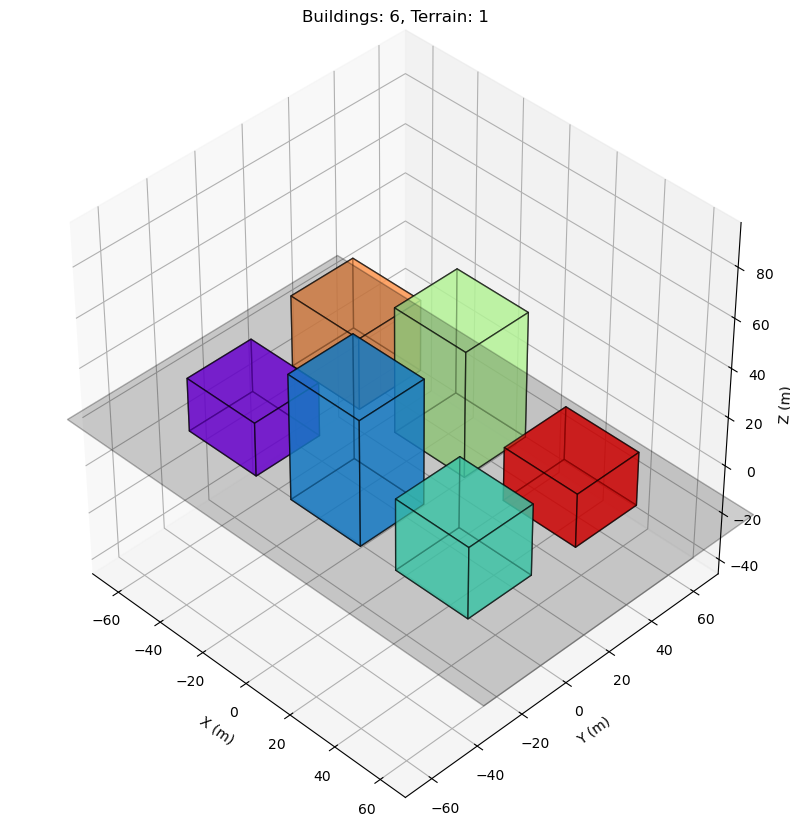

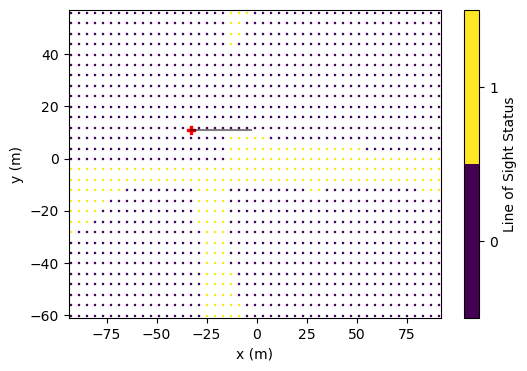

In [18]:
# Convert to DeepMIMO dataset format
scen_name_sionna = dm.convert(save_folder, overwrite=True)

# Load the dataset
dataset = dm.load(scen_name_sionna)

if type(dataset) == dm.MacroDataset:  # multiple tx-rx pairs in the same scenario
    dataset[0].los.plot()
else:
    dataset.los.plot()

print("TX position:", dataset.tx_pos)

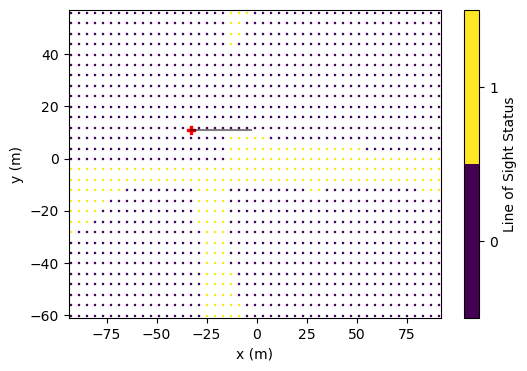

In [20]:
dataset.los.plot()

In [4]:
# Compute channels
# For synthetic_array = True (far-field assumption)
ch_params = dm.ChannelParameters()

# Automatically calculate the number of TX antennas
num_tx_antennas = scene.tx_array.num_ant
print(f"Number of TX antennas: {num_tx_antennas}")
ch_params.bs_antenna.shape = (num_tx_antennas, 1)  # Automatically match the number of TX antennas

dataset.compute_channels(ch_params)

# Concatenate channels from all paths
channels = np.concatenate(dataset.channels, axis=1)
print(f"Channel shape: {channels.shape}")


Number of TX antennas: 4


Generating channels: 100%|██████████| 1410/1410 [00:00<00:00, 14580.75it/s]

Channel shape: (1, 5640, 1)


### Done for DM conversion for Sionna v1 (Synthetic array = True)

### Synthetic array False

In [5]:
import deepmimo as dm
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import sionna
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, DirectivePattern, PathSolver
from deepmimo.exporters.sionna_exporter import export_paths


carrier_freq = 3.5 * 1e9  # Hz
tx_pos = [-33, 11, 32.03]

def compute_array_combinations(arrays):
    return np.stack(np.meshgrid(*arrays), -1).reshape(-1, len(arrays))

def gen_user_grid(box_corners, steps, box_offsets=None):
    """
    box_corners is = [bbox_min_corner, bbox_max_corner]
    steps = [x_step, y_step, z_step]
    """

    # Sample the ranges of coordinates
    ndim = len(box_corners[0])
    dim_ranges = []
    for dim in range(ndim):
        if steps[dim]:
            dim_range = np.arange(box_corners[0][dim], box_corners[1][dim], steps[dim])
        else:
            dim_range = np.array([box_corners[0][dim]]) # select just the first limit

        dim_ranges.append(dim_range + box_offsets[dim] if box_offsets else 0)

    pos = compute_array_combinations(dim_ranges)
    print(f'Total positions generated: {pos.shape[0]}')
    return pos

print('Computing UEs positions')
rxs = gen_user_grid(box_corners=[(-93, -60, 0), (93, 60, 0)],
                    steps=[4, 4, 0], box_offsets=[0, 0, 2])

# Create scene with synthetic_array = False
def create_base_scene_false(scene_path, center_frequency):
    scene = load_scene(scene_path, merge_shapes=False)
    scene.frequency = center_frequency
    
    # TX array: 2x2
    scene.tx_array = PlanarArray(num_rows=2,
                                 num_cols=2,
                                 vertical_spacing=0.5,
                                 horizontal_spacing=0.5,
                                 pattern="iso",
                                 polarization="V")
    
    # RX array: 1x1
    scene.rx_array = PlanarArray(num_rows=1,
                                 num_cols=1,
                                 vertical_spacing=0.5,
                                 horizontal_spacing=0.5,
                                 pattern="iso",
                                 polarization="V")
    
    scene.synthetic_array = False  # Key difference!

    return scene

# Path solver setup
path_solver_false = PathSolver()

# Save dict with compute path params for synthetic_array = False
my_compute_path_params_false = dict(
    max_depth=5,
    los=True,
    specular_reflection=True,
    diffuse_reflection=False,
    refraction=True,
    synthetic_array=False,  # Key difference!
    seed=42
)

# Create scene with synthetic_array = False
scene_false = create_base_scene_false(sionna.rt.scene.simple_street_canyon,
                                      center_frequency=carrier_freq)

# 1- Compute TX position
print('Computing BS position (synthetic_array=False)')
tx_false = Transmitter(name="tx", position=tx_pos, orientation=[0,0,0])
tx_false.antenna = scene_false.tx_array
scene_false.add(tx_false)

# 2- Compute RXs positions (reuse same grid)
print('Adding users to the scene (synthetic_array=False)')
n_rx_in_scene_false = 10  # to compute in parallel
for rx_idx in range(n_rx_in_scene_false):
    rx_false = Receiver(name=f"rx_{rx_idx}", position=rxs[rx_idx], orientation=[0,0,0])
    rx_false.antenna = scene_false.rx_array
    scene_false.add(rx_false)

# 3- Enable scattering in the radio materials (if needed)
if my_compute_path_params_false.get('diffuse_reflection', False):
    for rm in scene_false.radio_materials.values():
        rm.scattering_coefficient = 1/np.sqrt(3) # [0,1]
        rm.scattering_pattern = DirectivePattern(alpha_r=10)

Computing UEs positions
Total positions generated: 1410
Computing BS position (synthetic_array=False)
Adding users to the scene (synthetic_array=False)


In [6]:
# 4- Compute the paths for synthetic_array = False (receivers already added in Cell 7)
n_rx = len(rxs)
path_list_false = []
n_rx_remaining_false = n_rx
for x in tqdm(range(int(n_rx / n_rx_in_scene_false)+1), desc='Path computation (synthetic_array=False)'):
    if n_rx_remaining_false > 0:
        n_rx_remaining_false -= n_rx_in_scene_false
    else:
        break
    if x != 0:
        # modify current RXs in scene
        for rx_idx in range(n_rx_in_scene_false):
            if rx_idx + n_rx_in_scene_false*x < n_rx:
                scene_false.receivers[f'rx_{rx_idx}'].position = rxs[rx_idx + n_rx_in_scene_false*x]
            else:
                # remove the last receivers in the scene
                scene_false.remove(f'rx_{rx_idx}')

    paths_false = path_solver_false(scene=scene_false, **my_compute_path_params_false)

    paths_false.normalize_delays = False  # sum min_tau to tau, or tau of 1st path is always = 0

    path_list_false.append(export_paths(paths_false)[0])


Path computation (synthetic_array=False):  99%|█████████▉| 141/142 [02:39<00:01,  1.13s/it]


In [7]:
# Export to DeepMIMO format (synthetic_array = False)
from deepmimo.exporters import sionna_exporter
save_folder_false = 'sionna_test_scen_v1_false'

sionna_exporter.sionna_exporter(scene_false, path_list_false, my_compute_path_params_false, save_folder_false)


Determining converter...
Using Sionna RT converter
converting from sionna RT


Processing receivers for TX 0, Ant 3: 100%|██████████| 1410/1410 [00:00<00:00, 27194.79it/s]


Loading TXRX PAIR: TXset 0 (tx_idx 0) & RXset 1 (rx_idxs 1410)
Loading TXRX PAIR: TXset 0 (tx_idx 1) & RXset 1 (rx_idxs 1410)
Loading TXRX PAIR: TXset 0 (tx_idx 2) & RXset 1 (rx_idxs 1410)
Loading TXRX PAIR: TXset 0 (tx_idx 3) & RXset 1 (rx_idxs 1410)
TX position (synthetic_array=False): [array([-33.      ,  10.978586,  32.05141 ], dtype=float32), array([-33.      ,  10.978586,  32.008587], dtype=float32), array([-33.      ,  11.021414,  32.05141 ], dtype=float32), array([-33.      ,  11.021414,  32.008587], dtype=float32)]


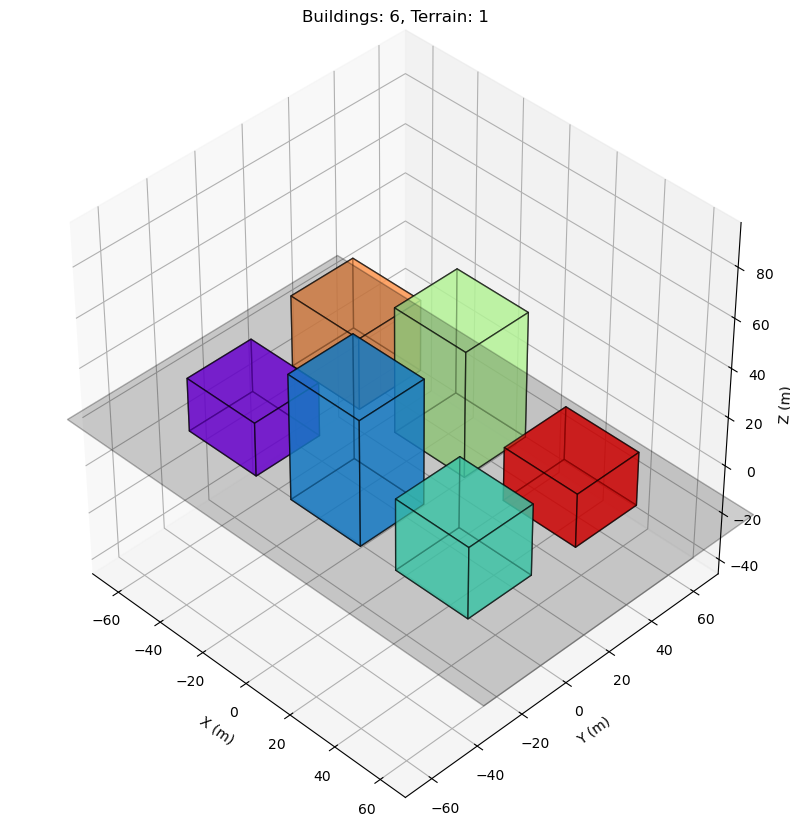

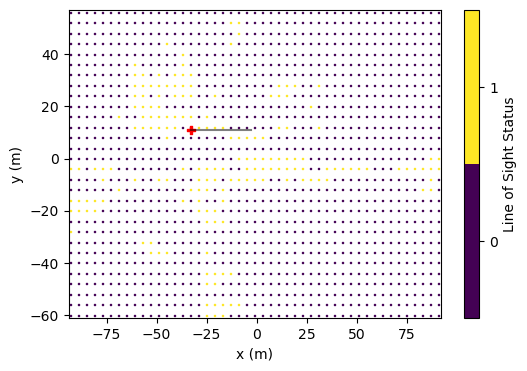

In [8]:
# Convert to DeepMIMO dataset format (synthetic_array = False)
scen_name_sionna_false = dm.convert(save_folder_false, overwrite=True)

# Load the dataset
dataset_false = dm.load(scen_name_sionna_false)

if type(dataset_false) == dm.MacroDataset:  # multiple tx-rx pairs in the same scenario
    dataset_false[0].los.plot()
else:
    dataset_false.los.plot()

print("TX position (synthetic_array=False):", dataset_false.tx_pos)

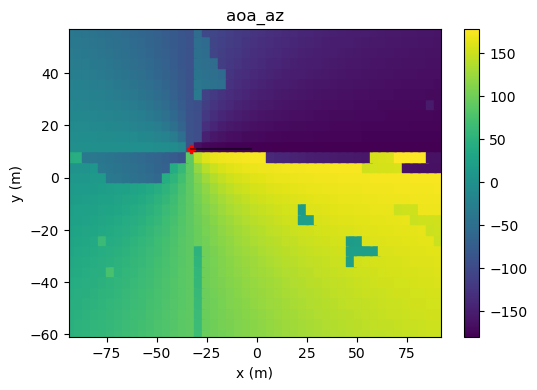

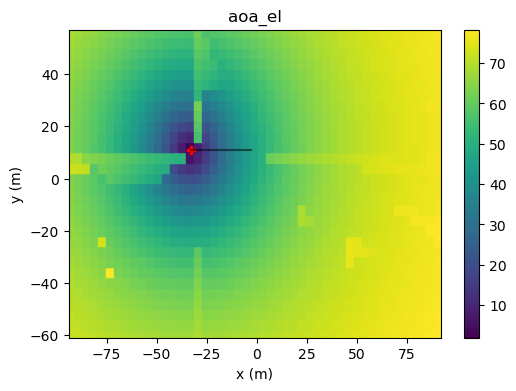

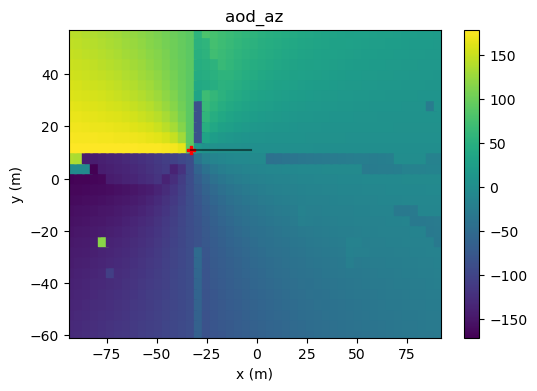

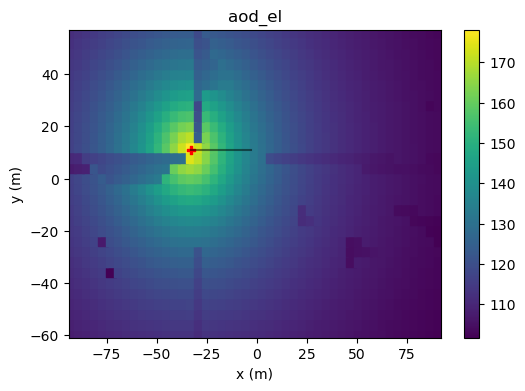

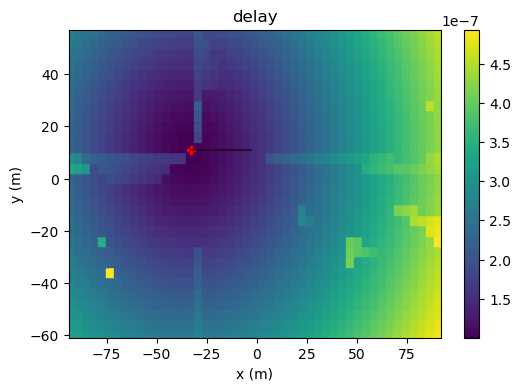

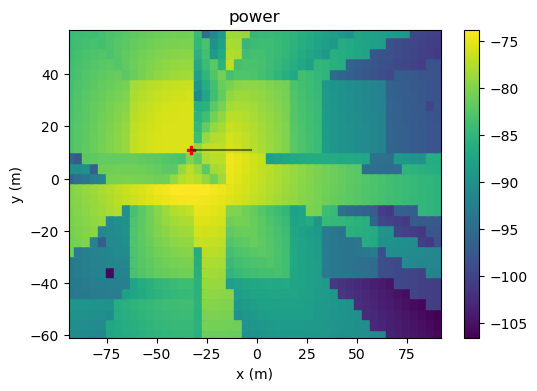

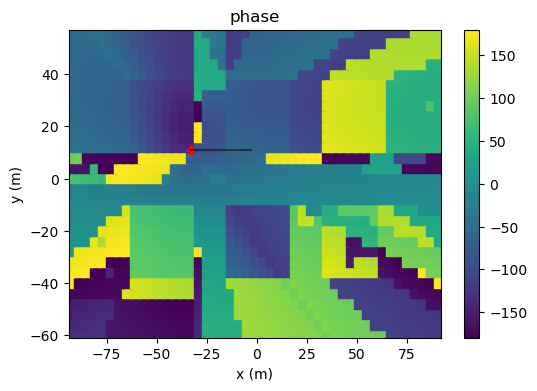

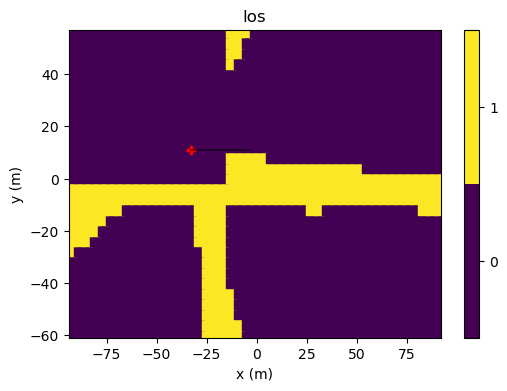

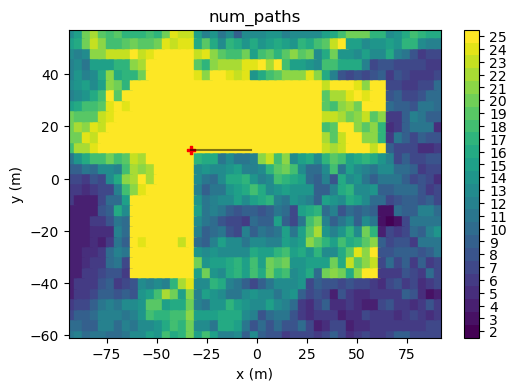

In [25]:
main_keys = ['aoa_az', 'aoa_el', 'aod_az', 'aod_el', 'delay', 'power', 'phase',
             'los', 'num_paths']

for key in main_keys:
    mat = dataset[key]
    plt_var = mat[:,0] if mat.ndim == 2 else mat
    dataset.plot_coverage(plt_var, title=key, scat_sz=50)

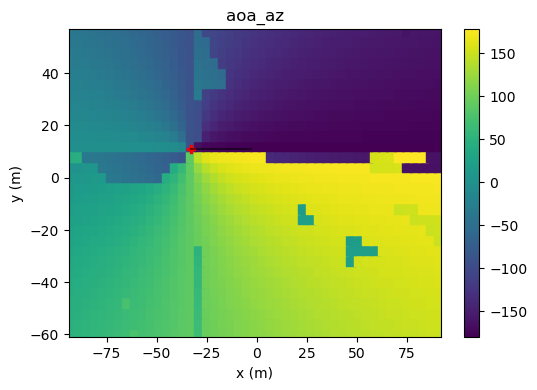

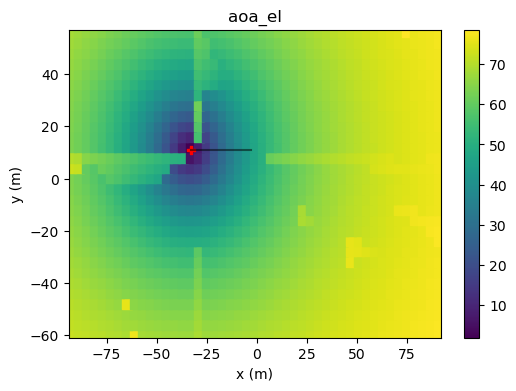

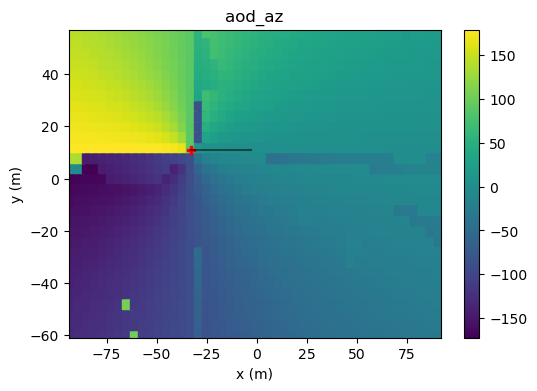

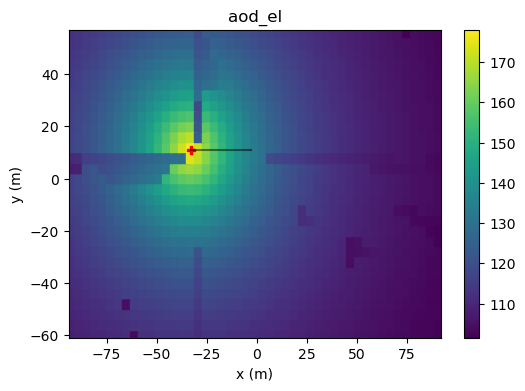

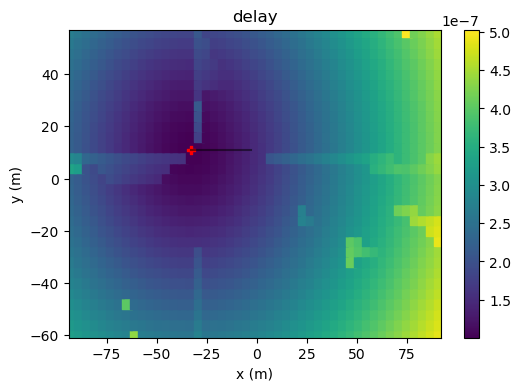

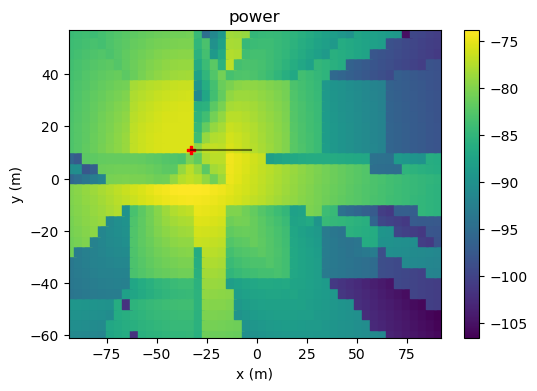

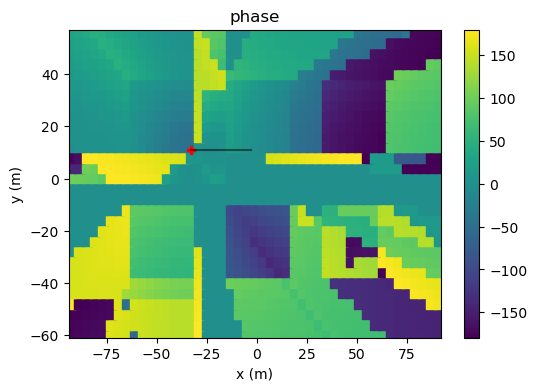

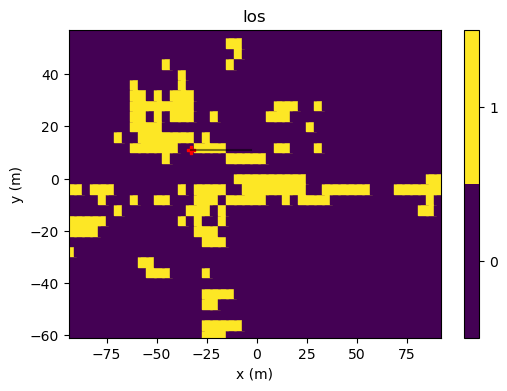

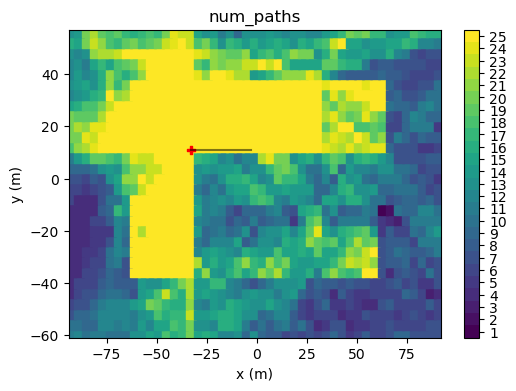

In [27]:
main_keys = ['aoa_az', 'aoa_el', 'aod_az', 'aod_el', 'delay', 'power', 'phase',
             'los', 'num_paths']

for key in main_keys:
    mat = dataset_false[0][key]
    plt_var = mat[:,0] if mat.ndim == 2 else mat
    dataset_false[0].plot_coverage(plt_var, title=key, scat_sz=50)

In [11]:
# Compute channels for synthetic_array = False
ch_params_false = dm.ChannelParameters()

# For synthetic_array = False, we need to combine all 4 antenna channels for fair comparison
num_tx_antennas_false = scene_false.tx_array.num_ant
print(f"Number of TX antennas (synthetic_array=False): {num_tx_antennas_false}")

# For synthetic_array = False, use (1,1) as per sionna_v1.py
ch_params_false.bs_antenna.shape = (1, 1)  # Individual antenna processing
print(f"Using antenna shape: {ch_params_false.bs_antenna.shape}")

dataset_false.compute_channels(ch_params_false)

# Check the type and structure of channels for synthetic_array=False
print(f"Channels type: {type(dataset_false.channels)}")
print(f"Number of channel arrays: {len(dataset_false.channels)}")

# Examine each channel array (one per antenna)
for i, ch in enumerate(dataset_false.channels):
    print(f"  Antenna {i} channels shape: {ch.shape}")

# Understand the dimension meaning
print(f"\n🔍 Dimension Analysis:")
print(f"  Shape: (1410, 1, 4, 1)")
print(f"         ^^^^  ^  ^  ^")
print(f"         RX   RX  TX  Freq")
print(f"        count ant ant")
print(f"")
print(f"  Meaning: Each 'antenna array' contains:")
print(f"  • 1410 receivers")
print(f"  • 1 RX antenna element") 
print(f"  • 4 TX antenna elements (2x2 array)")
print(f"  • 1 frequency/path component")
print(f"")
print(f"💡 Insight: synthetic_array=False calculates individual")
print(f"   TX-RX antenna pair channels, so each 'antenna' dataset")
print(f"   actually contains channels to ALL 4 TX antennas!")

# Following sionna_v1.py approach: concatenate along axis=1
channels_false_combined = np.concatenate(dataset_false.channels, axis=1)  # axis=1 as per sionna_v1.py
print(f"Concatenated channels shape: {channels_false_combined.shape}")

# Reshape for comparison (following the pattern)
channels_false_reshaped = channels_false_combined.reshape(1, -1, 1)
print(f"Reshaped for comparison: {channels_false_reshaped.shape}")

# For comparison with synthetic_array=True
print(f"\n🔍 Final Comparison:")
try:
    print(f"synthetic_array=True:  {channels.shape}")
    print(f"synthetic_array=False: {channels_false_reshaped.shape}")
    comparison_available = True
except NameError:
    print(f"⚠️  synthetic_array=True channels not found.")
    print(f"   Please run Cells 1-4 first to compute synthetic_array=True channels.")
    print(f"synthetic_array=False: {channels_false_reshaped.shape}")
    comparison_available = False

# Store versions for analysis (following sionna_v1.py approach)
channels_false_individual = dataset_false.channels    # List - individual antenna channels  
channels_false_final = channels_false_reshaped       # Final reshaped version for comparison


Number of TX antennas (synthetic_array=False): 4
Using antenna shape: (1, 1)


Generating channels: 100%|██████████| 1410/1410 [00:00<00:00, 13280.45it/s]

Channels type: <class 'list'>
Number of channel arrays: 4
  Antenna 0 channels shape: (1410, 1, 1, 1)
  Antenna 1 channels shape: (1410, 1, 1, 1)
  Antenna 2 channels shape: (1410, 1, 1, 1)
  Antenna 3 channels shape: (1410, 1, 1, 1)

🔍 Dimension Analysis:
  Shape: (1410, 1, 4, 1)
         ^^^^  ^  ^  ^
         RX   RX  TX  Freq
        count ant ant

  Meaning: Each 'antenna array' contains:
  • 1410 receivers
  • 1 RX antenna element
  • 4 TX antenna elements (2x2 array)
  • 1 frequency/path component

💡 Insight: synthetic_array=False calculates individual
   TX-RX antenna pair channels, so each 'antenna' dataset
   actually contains channels to ALL 4 TX antennas!
Concatenated channels shape: (1410, 4, 1, 1)
Reshaped for comparison: (1, 5640, 1)

🔍 Final Comparison:
synthetic_array=True:  (1, 5640, 1)
synthetic_array=False: (1, 5640, 1)


In [14]:
# 🔍 Detailed Comparison: synthetic_array=True vs False

print("🔍 DETAILED COMPARISON: synthetic_array=True vs False")
print("="*60)

try:
    # Check if both variables exist
    channels_true = channels
    channels_false = channels_false_final
    
    print("✅ Both channel datasets available for comparison\n")
    
    # 1. Basic Shape and Size Comparison
    print("📐 1. SHAPE & SIZE COMPARISON:")
    print(f"  True  shape: {channels_true.shape}")
    print(f"  False shape: {channels_false.shape}")
    print(f"  Same shape: {channels_true.shape == channels_false.shape}")
    print(f"  True  total elements: {channels_true.size:,}")
    print(f"  False total elements: {channels_false.size:,}")
    print(f"  Size ratio (False/True): {channels_false.size / channels_true.size:.2f}x")
    print()
    
    # 2. Statistical Comparison
    print("📊 2. STATISTICAL COMPARISON:")
    
    # Convert to magnitude for analysis
    mag_true = np.abs(channels_true.flatten())
    mag_false = np.abs(channels_false.flatten())
    
    print(f"  {'Metric':<15} {'True':<12} {'False':<12} {'Difference':<12}")
    print(f"  {'-'*15} {'-'*12} {'-'*12} {'-'*12}")
    print(f"  {'Mean':<15} {np.mean(mag_true):<12.6f} {np.mean(mag_false):<12.6f} {np.mean(mag_false)-np.mean(mag_true):<12.6f}")
    print(f"  {'Std Dev':<15} {np.std(mag_true):<12.6f} {np.std(mag_false):<12.6f} {np.std(mag_false)-np.std(mag_true):<12.6f}")
    print(f"  {'Min':<15} {np.min(mag_true):<12.6f} {np.min(mag_false):<12.6f} {np.min(mag_false)-np.min(mag_true):<12.6f}")
    print(f"  {'Max':<15} {np.max(mag_true):<12.6f} {np.max(mag_false):<12.6f} {np.max(mag_false)-np.max(mag_true):<12.6f}")
    print(f"  {'Median':<15} {np.median(mag_true):<12.6f} {np.median(mag_false):<12.6f} {np.median(mag_false)-np.median(mag_true):<12.6f}")
    print()
    
    # 3. Distribution Analysis
    print("📈 3. DISTRIBUTION ANALYSIS:")
    
    # Percentiles
    percentiles = [10, 25, 50, 75, 90, 95, 99]
    print(f"  {'Percentile':<12} {'True':<12} {'False':<12} {'Ratio':<12}")
    print(f"  {'-'*12} {'-'*12} {'-'*12} {'-'*12}")
    for p in percentiles:
        p_true = np.percentile(mag_true, p)
        p_false = np.percentile(mag_false, p)
        ratio = p_false / p_true if p_true != 0 else float('inf')
        print(f"  {f'{p}th':<12} {p_true:<12.6f} {p_false:<12.6f} {ratio:<12.3f}")
    print()
    
    # 4. Correlation Analysis
    print("🔗 4. CORRELATION ANALYSIS:")
    
    # Since shapes might be different, we need to handle this carefully
    if channels_true.shape == channels_false.shape:
        correlation = np.corrcoef(mag_true, mag_false)[0,1]
        print(f"  Pearson correlation: {correlation:.6f}")
        
        # Mean squared difference
        mse = np.mean((mag_true - mag_false)**2)
        print(f"  Mean Squared Error: {mse:.6f}")
        
        # Normalized MSE
        nmse = mse / np.var(mag_true)
        print(f"  Normalized MSE: {nmse:.6f}")
    else:
        print(f"  Cannot compute direct correlation - different shapes")
        print(f"  True samples: {len(mag_true):,}, False samples: {len(mag_false):,}")
    print()
    
    comparison_success = True
    
except NameError as e:
    missing_var = str(e).split("'")[1] if "'" in str(e) else "unknown"
    print(f"❌ Cannot perform comparison - missing variable: {missing_var}")
    print(f"   Please run the appropriate cells first:")
    if 'channels' in str(e):
        print(f"   - Run Cells 1-4 for synthetic_array=True (channels)")
    if 'channels_false' in str(e):
        print(f"   - Run Cells 7-11 for synthetic_array=False (channels_false_*)")
    comparison_success = False


🔍 DETAILED COMPARISON: synthetic_array=True vs False
✅ Both channel datasets available for comparison

📐 1. SHAPE & SIZE COMPARISON:
  True  shape: (1, 5640, 1)
  False shape: (1, 5640, 1)
  Same shape: True
  True  total elements: 5,640
  False total elements: 5,640
  Size ratio (False/True): 1.00x

📊 2. STATISTICAL COMPARISON:
  Metric          True         False        Difference  
  --------------- ------------ ------------ ------------
  Mean            0.000003     0.000003     -0.000000   
  Std Dev         0.000002     0.000002     -0.000000   
  Min             0.000000     0.000000     0.000000    
  Max             0.000018     0.000012     -0.000006   
  Median          0.000002     0.000002     -0.000000   

📈 3. DISTRIBUTION ANALYSIS:
  Percentile   True         False        Ratio       
  ------------ ------------ ------------ ------------
  10th         0.000000     0.000000     0.902       
  25th         0.000001     0.000001     0.936       
  50th         0.000002  

📊 5. VISUAL ANALYSIS:


/var/folders/xy/5vwtyfb50617t9ss_qwj26180000gn/T/ipykernel_7763/1229835700.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[1,1].boxplot(box_data, labels=box_labels, patch_artist=True)


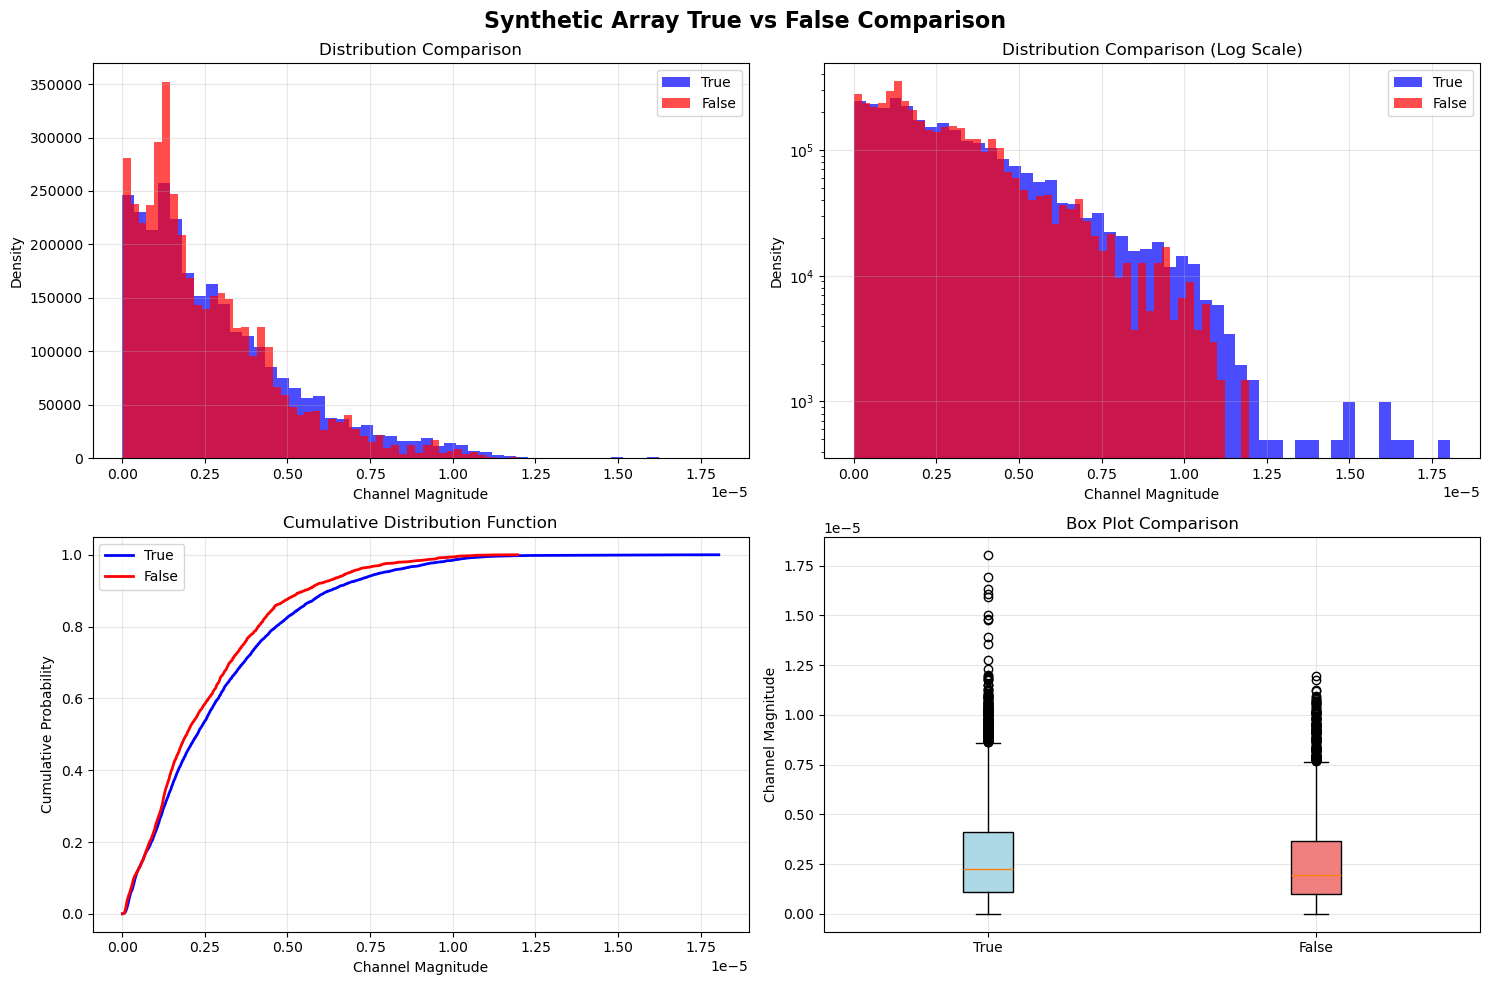


🎯 6. PHYSICAL INTERPRETATION:
  📡 synthetic_array=True (Far-field):
    • Antenna array treated as single coherent element
    • Far-field approximation applied
    • Combined array response computed
    • Faster computation, less detailed spatial info

  📡 synthetic_array=False (Near-field):
    • Each antenna element modeled individually
    • Actual geometric positions considered
    • Individual antenna pair channels computed
    • More accurate for near-field scenarios

🎯 7. SUMMARY & RECOMMENDATIONS:
  📈 Mean magnitude ratio (False/True): 0.884
  📊 Variance ratio (False/True): 0.752
  → True case shows higher average channel gains
  → True case shows more channel variability

  💡 Use synthetic_array=True for:
    • Large-scale coverage studies
    • Far-field communications
    • Faster simulations

  💡 Use synthetic_array=False for:
    • Near-field beamforming
    • Detailed spatial analysis
    • Small cell deployments


In [15]:
# 📊 Visual Comparison and Analysis

if 'comparison_success' in locals() and comparison_success:
    
    print("📊 5. VISUAL ANALYSIS:")
    
    # Create subplots for comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Synthetic Array True vs False Comparison', fontsize=16, fontweight='bold')
    
    # 5.1 Histogram comparison
    axes[0,0].hist(mag_true, bins=50, alpha=0.7, label='True', density=True, color='blue')
    axes[0,0].hist(mag_false, bins=50, alpha=0.7, label='False', density=True, color='red')
    axes[0,0].set_xlabel('Channel Magnitude')
    axes[0,0].set_ylabel('Density')
    axes[0,0].set_title('Distribution Comparison')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 5.2 Log-scale histogram
    axes[0,1].hist(mag_true, bins=50, alpha=0.7, label='True', density=True, color='blue')
    axes[0,1].hist(mag_false, bins=50, alpha=0.7, label='False', density=True, color='red')
    axes[0,1].set_xlabel('Channel Magnitude')
    axes[0,1].set_ylabel('Density')
    axes[0,1].set_title('Distribution Comparison (Log Scale)')
    axes[0,1].set_yscale('log')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # 5.3 Cumulative Distribution Function
    x_true = np.sort(mag_true)
    y_true = np.arange(1, len(x_true) + 1) / len(x_true)
    x_false = np.sort(mag_false)
    y_false = np.arange(1, len(x_false) + 1) / len(x_false)
    
    axes[1,0].plot(x_true, y_true, label='True', color='blue', linewidth=2)
    axes[1,0].plot(x_false, y_false, label='False', color='red', linewidth=2)
    axes[1,0].set_xlabel('Channel Magnitude')
    axes[1,0].set_ylabel('Cumulative Probability')
    axes[1,0].set_title('Cumulative Distribution Function')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 5.4 Box plot comparison
    box_data = [mag_true, mag_false]
    box_labels = ['True', 'False']
    box_plot = axes[1,1].boxplot(box_data, labels=box_labels, patch_artist=True)
    box_plot['boxes'][0].set_facecolor('lightblue')
    box_plot['boxes'][1].set_facecolor('lightcoral')
    axes[1,1].set_ylabel('Channel Magnitude')
    axes[1,1].set_title('Box Plot Comparison')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 6. Physical Interpretation
    print("\n🎯 6. PHYSICAL INTERPRETATION:")
    print("  📡 synthetic_array=True (Far-field):")
    print("    • Antenna array treated as single coherent element")
    print("    • Far-field approximation applied")
    print("    • Combined array response computed")
    print("    • Faster computation, less detailed spatial info")
    print()
    print("  📡 synthetic_array=False (Near-field):")
    print("    • Each antenna element modeled individually")
    print("    • Actual geometric positions considered")
    print("    • Individual antenna pair channels computed")
    print("    • More accurate for near-field scenarios")
    print()
    
    # 7. Summary and Recommendations
    print("🎯 7. SUMMARY & RECOMMENDATIONS:")
    magnitude_ratio = np.mean(mag_false) / np.mean(mag_true)
    variance_ratio = np.var(mag_false) / np.var(mag_true)
    
    print(f"  📈 Mean magnitude ratio (False/True): {magnitude_ratio:.3f}")
    print(f"  📊 Variance ratio (False/True): {variance_ratio:.3f}")
    
    if magnitude_ratio > 1.1:
        print("  → False case shows higher average channel gains")
    elif magnitude_ratio < 0.9:
        print("  → True case shows higher average channel gains")
    else:
        print("  → Similar average channel gains between approaches")
    
    if variance_ratio > 1.1:
        print("  → False case shows more channel variability")
    elif variance_ratio < 0.9:
        print("  → True case shows more channel variability") 
    else:
        print("  → Similar channel variability between approaches")
    
    print("\n  💡 Use synthetic_array=True for:")
    print("    • Large-scale coverage studies")
    print("    • Far-field communications")
    print("    • Faster simulations")
    print("\n  💡 Use synthetic_array=False for:")
    print("    • Near-field beamforming")
    print("    • Detailed spatial analysis")
    print("    • Small cell deployments")

else:
    print("⚠️  Cannot perform visual analysis - comparison data not available")
    print("   Please run the previous comparison cell successfully first")


In [16]:
# 📋 Quick Summary of Key Differences

if 'comparison_success' in locals() and comparison_success:
    print("📋 QUICK SUMMARY - KEY DIFFERENCES")
    print("="*50)
    
    # Calculate key metrics
    mean_diff_pct = ((np.mean(mag_false) - np.mean(mag_true)) / np.mean(mag_true)) * 100
    std_diff_pct = ((np.std(mag_false) - np.std(mag_true)) / np.std(mag_true)) * 100
    max_diff_pct = ((np.max(mag_false) - np.max(mag_true)) / np.max(mag_true)) * 100
    
    print(f"📊 Statistical Differences:")
    print(f"  • Mean difference: {mean_diff_pct:+.2f}%")
    print(f"  • Std Dev difference: {std_diff_pct:+.2f}%") 
    print(f"  • Max value difference: {max_diff_pct:+.2f}%")
    print()
    
    print(f"📐 Data Structure:")
    print(f"  • True:  {channels_true.shape} = {channels_true.size:,} elements")
    print(f"  • False: {channels_false.shape} = {channels_false.size:,} elements")
    print(f"  • Size ratio: {channels_false.size/channels_true.size:.1f}×")
    print()
    
    print(f"⚡ Computational Approach:")
    print(f"  • True:  Far-field, combined antenna response")
    print(f"  • False: Individual antenna element modeling")
    print()
    
    print(f"🎯 Recommendation:")
    if abs(mean_diff_pct) < 5:
        print(f"  ✅ Similar results - choice depends on use case")
    elif mean_diff_pct > 5:
        print(f"  📈 False gives {abs(mean_diff_pct):.1f}% higher values")
    else:
        print(f"  📉 True gives {abs(mean_diff_pct):.1f}% higher values")
        
else:
    print("📋 Quick summary not available - please run comparison analysis first")


📋 QUICK SUMMARY - KEY DIFFERENCES
📊 Statistical Differences:
  • Mean difference: -11.63%
  • Std Dev difference: -13.27%
  • Max value difference: -33.71%

📐 Data Structure:
  • True:  (1, 5640, 1) = 5,640 elements
  • False: (1, 5640, 1) = 5,640 elements
  • Size ratio: 1.0×

⚡ Computational Approach:
  • True:  Far-field, combined antenna response
  • False: Individual antenna element modeling

🎯 Recommendation:
  📉 True gives 11.6% higher values
